In [2]:
using LightGraphs, GraphPlot

In [64]:
@inline function splitwhile(s::AbstractString, predicate::Function)
    i = 1
    for c in s
        if !predicate(c)
            break
        end
        
        i += 1
    end
    
    return s[1:i-1], s[i:end]
end

"Read a space separated file into an (undirected) Graph in an efficient way."
function readnetwork(filename::String, limit::Number = Inf; fromzero::Bool = false)
    #edges = parse(readstring(pipeline(`grep -v '^#' $filename`, `wc -l`)))
    
    graph = Graph()
    vertices = 0
    correction = Int(fromzero)
    
    # using grep to exclude comment lines
    open(`grep -v '^#' $filename`) do file
        for (l, line) in enumerate(eachline(file))
            if l > limit
                break
            end

            #a, b = map(e -> parse(e) + correction, matchall(r"\d+", line))
            rawa, rest = splitwhile(line, isdigit)
            _, rawb = splitwhile(rest, isspace)
            a = parse(Int, rawa) + correction
            b = parse(Int, rawb) + correction
            
            if a > vertices || b > vertices
                @assert add_vertices!(graph, max(a, b) - vertices)
                vertices = max(a, b)
            end
            
        # we explicitely ignore inverse directions, if there are any
        @assert has_edge(graph, a, b) || add_edge!(graph, a, b)
        end
    end

    return graph
end

readnetwork

In [72]:
@inline function choosestart(translation::Dict{Int, Int}, vertices::Int)
    next = rand(1:vertices)
    while haskey(translation, next)
        next = rand(1:vertices)
    end
            
    return next
end

"Samples from a network graph using a random walk until n nodes are visited"
function samplenetwork(graph::Graph, n::Integer)
    @assert n >= 0
    
    if n == 0
        return Graph()
    end
    
    step = 0
    walk_limit = round(Int, 100 / log10(n + 1) * n)
    vertices = nv(graph)
    
    last = rand(1:vertices)
    
    translation = Dict(last => 1)
    sizehint!(translation, n)
    
    node_count = 1
    sample = Graph(n)

    
    while node_count < n
        candidates = neighbors(graph, last)
        
        # we chose a component of size 1: reinitialize
        if isempty(candidates)
            last = choosestart(translation, vertices)
            node_count += 1
            translation[last] = node_count
            step = 0
            continue
        end
        
        next = rand(candidates)
    
        if !haskey(translation, next)
            node_count += 1
            translation[next] = node_count
        end
        
        add_edge!(sample, translation[last], translation[next])
        
        if step < walk_limit
            last = next
            step += 1
        else
            # reinitialize; maybe stuck in component
            last = choosestart(translation, vertices)
            node_count += 1
            translation[last] = node_count
            step = 0
        end
    end
    
    return sample
end

samplenetwork

In [59]:
roads_europe = readnetwork("roads-europe.txt")

{1174, 1417} undirected graph

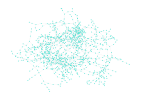

In [73]:
s = samplenetwork(roads_europe, 1000)
gplot(s)

In [65]:
roads_texas = readnetwork("roads-texas.txt"; fromzero = true)

{1393383, 1921660} undirected graph

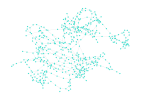

In [71]:
s = samplenetwork(roads_texas, 500)
gplot(s)